In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, roc_auc_score, 
    f1_score, accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay)

pd.set_option('display.max_colwidth', None)

In [2]:
cards_data = pd.read_csv(
    f"../datasets/augmented/9834838408490912248/cards_augmented_0_V1.csv")
augmentedv1 = pd.read_csv(
    f"../datasets/generated_disinformation/taxonomy/CHATGPT_V1.csv")
augmentedv1["DATASET"] = "CHATGPT (1)"
augmentedv1["claim"] = augmentedv1["generated_label"] 

augmentedv2 = pd.read_csv(
    f"../datasets/generated_disinformation/taxonomy/CHATGPT_V22.csv")
augmentedv2["DATASET"] = "CHATGPT2 (2)"
augmentedv2["claim"] = augmentedv2["generated_label"] 

augmentedv3 = pd.read_csv(
    f"../datasets/generated_disinformation/taxonomy/GPT-4_V2.csv")
augmentedv3["DATASET"] = "GPT-4 (1)"
augmentedv3["claim"] = augmentedv3["generated_label"]

augmentedv4 = pd.read_csv(
    f"../datasets/generated_disinformation/taxonomy/GPT-4_V3.csv")
augmentedv4["DATASET"] = "GPT-4 (2)"
augmentedv4["claim"] = augmentedv4["generated_label"]

data = pd.concat([cards_data, augmentedv1, augmentedv2, augmentedv3, augmentedv4])
data.DATASET.value_counts()

cards           28945
CHATGPT (1)     18891
CHATGPT2 (2)     8500
GPT-4 (1)        4490
GPT-4 (2)         800
Name: DATASET, dtype: int64

### GPT-4 (1)

In [3]:
gpt4v2 = data[data.DATASET=="GPT-4 (1)"].copy()
print(gpt4v2.shape)
gpt4v2.loc[:2, ["text", "claim"]]

(4490, 12)


,text,claim
0,"New research suggests that Arctic sea ice may be more resilient than previously believed, as satellite data shows stable sea ice volumes in spring months from 2010 to 2014 and increased volumes in Autumn 2013 and 2014, indicating that the snow is not melting as rapidly as once thought.",1_1
1,"Despite concerns about global warming, recent observations indicate that snow is not melting as expected, with sea ice in the Southern Ocean reaching its highest extent in decades and a near-zero trend in Arctic September sea-ice extent from 2007-2013.",1_1
2,"Despite concerns about global warming, recent observations indicate that snow is not melting as expected, with sea ice in the Southern Ocean reaching its highest extent in decades and a near-zero trend in Arctic September sea-ice extent from 2007-2013.",1_1


More than 2 thousand duplicated samples were removed.

In [4]:
gpt4v2 = gpt4v2.drop_duplicates("text")
gpt4v2.shape

(4459, 12)

In [5]:
def cards_pred(data):
    preds = (
        data.groupby(["claim", "cards_aug_pred"]).text.count().rename("count").to_frame().reset_index())

    label_counts = data.claim.value_counts()
    preds["total"] = preds.claim.apply(lambda x: label_counts[x])
    preds["accuracy"] = preds['count'] / preds["total"]
    correct_clfs = preds[preds.claim==preds.cards_aug_pred].sort_values(["claim"])
    cm = sns.diverging_palette(10, 255, s=60, center="dark", as_cmap=True)
    return correct_clfs.style.background_gradient(cmap=cm, vmin=0, vmax=1, subset=pd.IndexSlice[:, ['accuracy']])
cards_pred(gpt4v2)

,claim,cards_aug_pred,count,total,accuracy
1,1_1,1_1,496,498,0.995984
4,1_2,1_2,498,499,0.997996
7,1_3,1_3,497,499,0.995992
9,1_4,1_4,494,499,0.989980
11,1_6,1_6,496,497,0.997988
14,1_7,1_7,498,499,0.997996
17,2_1,2_1,485,488,0.993852
20,2_3,2_3,92,96,0.958333
21,3_1,3_1,99,99,1.000000
22,3_2,3_2,99,99,1.000000


In [6]:
list_samples = ["0_V1", "GPT-4_V2"]
partition = ["TRAIN", "VALID", "TEST"]
labels = np.sort(data.claim.unique()).tolist()

reports = {}
seed = "9834838408490912248"

report = pd.DataFrame(index=labels)
for n in list_samples:
    augmented_cards = pd.read_csv(f"../datasets/augmented/{seed}/cards_augmented_{n}.csv")
    augmented_cards_partition = augmented_cards[augmented_cards.PARTITION=="TEST"]
    support = augmented_cards[augmented_cards.PARTITION=="TRAIN"].claim.value_counts()
    
    y_true = augmented_cards_partition.claim.values
    y_pred = augmented_cards_partition[f"cards_aug_pred"].values

    f1_labels = f1_score(y_true, y_pred, average=None, labels=labels, zero_division=0)
    report[n] = f1_labels
    report[n + "_support"] = support.astype("Int64")
    
report.loc["macro"] = report.mean()
cm = sns.diverging_palette(0, 255, n=256, sep=1, center="light", as_cmap=True)
report.style.background_gradient(cmap=cm, vmin=0, vmax=1, subset=pd.IndexSlice[:, ['0_V1', 'GPT-4_V2']])

,0_V1,0_V1_support,GPT-4_V2,GPT-4_V2_support
0_0,0.930583,16302.000000,0.762340,16302.000000
1_1,0.764045,333.000000,0.210526,500.000000
1_2,0.711111,147.000000,0.562500,500.000000
1_3,0.779661,229.000000,0.064516,500.000000
1_4,0.780142,483.000000,0.054795,500.000000
1_6,0.827586,189.000000,0.142857,500.000000
1_7,0.875000,427.000000,0.030303,500.000000
2_1,0.850202,788.000000,0.149254,490.000000
2_3,0.742268,339.000000,0.178571,100.000000
3_1,0.821429,207.000000,0.181818,100.000000


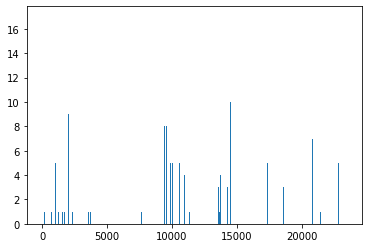

In [7]:
origins = gpt4v2.based_claims.apply(eval).tolist()
counts = {}
for o in origins:
    for i in o:
        if i in counts:
            counts[i]+=1
        else:
            counts[i]=0
    
index = cards_data[(cards_data.PARTITION=="TRAIN")&(cards_data.claim!="0_0")].index
counts = pd.DataFrame(counts.values(), index=counts.keys(), columns=["counts"]).sort_index()
plt.bar(counts.index, counts["counts"].values)
plt.show()

## GPT-4 (2)

In [8]:
gpt4v3 = data[data.DATASET=="GPT-4 (2)"].copy()
print(gpt4v3.shape)
gpt4v3 = gpt4v3.drop_duplicates("text")
print(gpt4v3.shape)
gpt4v3.loc[:2, ["text", "claim"]]

(800, 12)
(786, 12)


,text,claim
0,"Antarctica has been experiencing an increase in sea ice extent in recent years, contrary to the decline observed in the Arctic. This phenomenon has puzzled scientists, as it seems to contradict the overall trend of global warming.\n\n5. Some researchers suggest that the increase in Antarctic sea ice could be due to changes",1_1
1,"Antarctica has also been experiencing an increase in ice extent. According to the National Snow and Ice Data Center, Antarctic sea ice extent reached a record high in 2014, and although it has decreased slightly since then, it remains above average levels. This is due to a combination of factors,",1_1
2,"The Antarctic sea ice has been increasing in recent years, contrary to the predictions of climate models. This suggests that there may be factors at play that are not yet fully understood or accounted for in the models. Some scientists argue that the increase in Antarctic sea ice could be a temporary phenomenon, or a result",1_1


In [9]:
cards_pred(gpt4v3)

,claim,cards_aug_pred,count,total,accuracy
1,1_1,1_1,44,48,0.916667
3,1_2,1_2,50,50,1.000000
5,1_3,1_3,43,48,0.895833
7,1_4,1_4,47,50,0.940000
8,1_6,1_6,47,49,0.959184
12,1_7,1_7,41,47,0.872340
14,2_1,2_1,43,49,0.877551
19,2_3,2_3,36,50,0.720000
22,3_1,3_1,49,50,0.980000
24,3_2,3_2,25,50,0.500000


In [10]:
tmp = gpt4v3
preds = (
        tmp.groupby(["claim", "cards_aug_pred"]).text.count().rename("count").to_frame().reset_index())
label_counts = tmp.claim.value_counts()
preds["total"] = preds.claim.apply(lambda x: label_counts[x])
preds["proportion"] = preds['count'] / preds["total"]
correct_clfs = preds[preds.claim==preds.cards_aug_pred].sort_values(["claim"])
incorrect_clfs = preds[preds.claim!=preds.cards_aug_pred].sort_values(["proportion"], ascending=False)
cm = sns.diverging_palette(10, 255, s=60, center="dark", as_cmap=True)
incorrect_clfs.style.background_gradient(cmap=cm, vmin=0, vmax=1, subset=pd.IndexSlice[:, ['proportion']])

,claim,cards_aug_pred,count,total,proportion
25,3_2,3_3,25,50,0.500000
17,2_3,0_0,7,50,0.140000
11,1_7,0_0,6,47,0.127660
4,1_3,0_0,5,48,0.104167
29,4_2,4_1,5,49,0.102041
18,2_3,2_1,4,50,0.080000
32,4_5,0_0,3,47,0.063830
0,1_1,0_0,3,48,0.062500
15,2_1,2_3,3,49,0.061224
6,1_4,0_0,3,50,0.060000
